In [1]:
# install dependencies
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import torchvision.models as models # for ResNet

In [2]:
# Model Architecture from Proposal: We will use part of ResNet-50 as a feature extractor and to this we will connect a CNN to upscale the
#output features. The output of this pipeline will be feature maps of the same dimensionality as the input image.
# Each of these represents the heatmaps of a human joint landmark, as such a soft-arg max function can be applied to
# derive the coordinates of these points and a loss function can be applied.

class closedPose(nn.Module):
  def __init__(self, num_joints=13):
    super(closedPose, self).__init__()
    self.name = "pose"

    resnet = models.resnet50(pretrained=True) # (3,224,224) input to resnet -> feature map output dim (2048,7,7)
    self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2]) # remove layers: Global Pool, FC

    # Upscalling CNN
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1),  # Upscale x2
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Upscale x2
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upscale x2
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(128, num_joints, kernel_size=4, stride=2, padding=1), # one channel output for each joint
      nn.Sigmoid()  # Normalize, 0 to 1, for probability distribution
    )

  def forward(self, x):
    features = self.feature_extractor(x)
    heatmaps = self.decoder(features)
    return heatmaps

In [3]:
def soft_argmax(heatmaps):
    """
    Get the highest most likely (x, y) coordinates of a joint from the output heatmaps
    Arguments - heatmaps: (batch, num_joints, H, W) tensor
    Returns - coords: (batch, num_joints, 2) tensor, where the 2 is for (x,y)
    """
    batch_size, num_joints, H, W = heatmaps.shape

    # Apply spatial softmax: reshape to (batch, num_joints, H*W) and normalize
    heatmaps = heatmaps.view(batch_size, num_joints, -1)  # (batch, num_joints, H*W)
    heatmaps = F.softmax(heatmaps, dim=-1)  # (batch, num_joints, H*W), sum=1 across spatial dim

    # Create coordinate grids
    x_grid = torch.linspace(0, W - 1, W, device=heatmaps.device).repeat(H, 1).view(H * W)  # (H*W,)
    y_grid = torch.linspace(0, H - 1, H, device=heatmaps.device).repeat(W, 1).t().contiguous().view(H * W)  # (H*W,)

    # Compute expected x and y coordinates
    x = torch.sum(heatmaps * x_grid, dim=-1)  # (batch, num_joints)
    y = torch.sum(heatmaps * y_grid, dim=-1)  # (batch, num_joints)

    coords = torch.stack((x, y), dim=-1)
    return coords


In [4]:
def train(model, train_loader, val_loader, batch_size=15, learning_rate=0.001, num_epochs=150, device='cuda'):
    torch.manual_seed(420)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
  
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
      
        for images, labels in train_loader:
            # Here, ensure your images are the proper size (e.g. 224x224)
            # And scale labels appropriately. If your ground truth is normalized, multiply by target image size:
            labels = labels * 224  # adjust if needed (previously it was 220)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            heatmap_outputs = model(images)  # heatmap shape: (batch, 13, 112, 112)
            vector_output = soft_argmax(heatmap_outputs)  # (batch, 13, 2)
            # Scale output from 112-scale to 224-scale:
            vector_output = vector_output * 2
            vector_output = vector_output.view(vector_output.size(0), -1)  # flatten to (batch, 26)
            
            loss = criterion(vector_output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
      
        avg_train_loss = running_loss / len(train_loader)
      
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels * 224  # consistent scaling
                images, labels = images.to(device), labels.to(device)
                heatmap_outputs = model(images)
                vector_output = soft_argmax(heatmap_outputs)
                vector_output = vector_output * 2
                vector_output = vector_output.view(vector_output.size(0), -1)
                loss = criterion(vector_output, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        scheduler.step(avg_val_loss)
      
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
  
    return model

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from PIL import Image

import os
from pathlib import Path
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
class KeypointDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, max_images=None):
        """
        Args:
            images_dir (str or Path): Directory containing image files.
            labels_dir (str or Path): Directory containing label files.
            transform (callable, optional): A torchvision.transforms transformation to apply.
            max_images (int, optional): If set, cap the dataset to at most max_images images.
        """
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        # Only include images that have a matching label file.
        self.image_paths = [p for p in self.images_dir.glob("*.jpg")
                            if (self.labels_dir / f"{p.stem}.txt").exists()]
        if max_images is not None:
            self.image_paths = self.image_paths[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image.
        image_path = self.image_paths[idx]
        img = cv2.imread(str(image_path))
        if img is None:
            raise RuntimeError(f"Failed to load image: {image_path}")
        # Convert from BGR to RGB.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply transformations if provided (expects a PIL Image).
        if self.transform:
            img = Image.fromarray(img)
            image_tensor = self.transform(img)
        else:
            image_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0

        # Load keypoint labels.
        label_path = self.labels_dir / (image_path.stem + ".txt")
        with open(label_path, 'r') as f:
            line = f.readline().strip()
        parts = line.split()
        # Skip the first token (dummy class id).
        kp_values = parts[1:]
        # Convert to numpy array and reshape to (num_keypoints, 3)
        kp_array = np.array(kp_values, dtype=float).reshape(-1, 3)
        # Remove first entry of each keypoint (the class id)
        kp_array = kp_array[:, 0:2]
        # Convert to tensor.
        label_tensor = torch.tensor(kp_array, dtype=torch.float32)
        # Flatten the label tensor to match the network's output (batch x 26)
        label_tensor = label_tensor.view(-1)
        
        return image_tensor, label_tensor
def compute_pck(outputs, labels, threshold=0.1):
    """
    Compute the Percentage of Correct Keypoints (PCK) for a batch.
    
    Args:
        outputs (Tensor): Model predictions of shape (batch, 26).
        labels (Tensor): Ground truth of shape (batch, 26).
        threshold (float): If the Euclidean distance is below this value (normalized), the keypoint is correct.
    Returns:
        Average PCK over the batch.
    """
    batch_size = outputs.shape[0]
    # Reshape to (batch, 13, 2)
    outputs = outputs.view(batch_size, 13, 2)
    labels = labels.view(batch_size, 13, 2)
    # Compute Euclidean distances for each keypoint.
    distances = torch.norm(outputs - labels, dim=2)  # shape: (batch, 13)
    # Consider a keypoint correct if its distance is less than the threshold.
    correct = (distances < threshold).float()
    # Average correctness per sample.
    pck_per_sample = correct.mean(dim=1)
    # Average across the batch.
    return pck_per_sample.mean().item()
def evaluate(model, data_loader, threshold=0.2):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    total_pck = 0.0
    count = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0), -1)
            labels = labels.view(labels.size(0), -1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            # Compute PCK for the current batch.
            batch_pck = compute_pck(outputs, labels, threshold)
            total_pck += batch_pck * inputs.size(0)
            count += inputs.size(0)
    avg_loss = total_loss / count
    avg_pck = total_pck / count
    print(f'Validation Loss: {avg_loss:.4f}, PCK: {avg_pck*100:.2f}%')
    return avg_loss, avg_pck


import random
import numpy as np
random.seed(420)
np.random.seed(420)
torch.manual_seed(420)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.manual_seed_all(420)

In [ ]:
model = closedPose()

transform = transforms.Compose([
    transforms.ToTensor()
])


dataset = KeypointDataset('../datasets/train_subset_single/standardized_images',
                              '../datasets/train_subset_single/labels',
                              transform=transform,
                              max_images=500)

train_len, val_len, test_len = int(0.8 * len(dataset)), int(0.1 * len(dataset)), int(0.1 * len(dataset))

train_data, val_data, test_data = random_split(dataset, [train_len, val_len, test_len])


train_loader = DataLoader(train_data, batch_size=15, shuffle=True,pin_memory=True,num_workers=0)
val_loader = DataLoader(val_data, batch_size=15, shuffle=False,pin_memory=True,num_workers=0)
test_loader = DataLoader(test_data, batch_size=15, shuffle=False,pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


train(model, train_loader, val_loader, num_epochs=100,batch_size=15,learning_rate=0.009)

c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] Train Loss: 3977.3217, Val Loss: 4863.2325
Epoch [2/100] Train Loss: 3888.7212, Val Loss: 4732.3058
Epoch [3/100] Train Loss: 3947.5957, Val Loss: 4767.2288
Epoch [4/100] Train Loss: 3904.8640, Val Loss: 4694.7139
Epoch [5/100] Train Loss: 3890.9952, Val Loss: 4702.0664
Epoch [6/100] Train Loss: 3892.5521, Val Loss: 4656.9248
Epoch [7/100] Train Loss: 3940.8719, Val Loss: 4783.6155
Epoch [8/100] Train Loss: 3968.9059, Val Loss: 4808.4191
Epoch [9/100] Train Loss: 3971.4612, Val Loss: 4768.9023
Epoch [10/100] Train Loss: 3962.2809, Val Loss: 4800.7004
Epoch [11/100] Train Loss: 3976.3829, Val Loss: 4702.0925
Epoch [12/100] Train Loss: 3909.5112, Val Loss: 4706.8739
Epoch [13/100] Train Loss: 3948.4291, Val Loss: 4715.6884
Epoch [14/100] Train Loss: 3972.6058, Val Loss: 4722.9972
Epoch [15/100] Train Loss: 3941.4521, Val Loss: 4717.4152
Epoch [16/100] Train Loss: 3940.9895, Val Loss: 4722.9962
Epoch [17/100] Train Loss: 3971.3574, Val Loss: 4781.2063
Epoch [18/100] Train Lo

[[0. 0.]
 [0. 0.]
 [0. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]


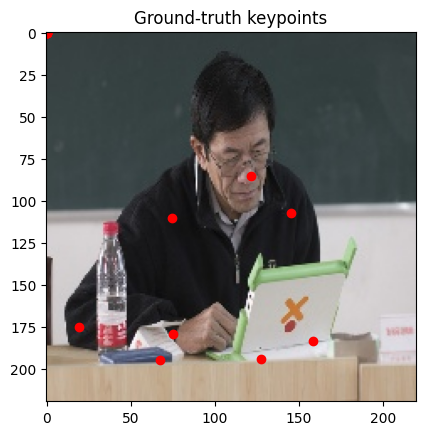

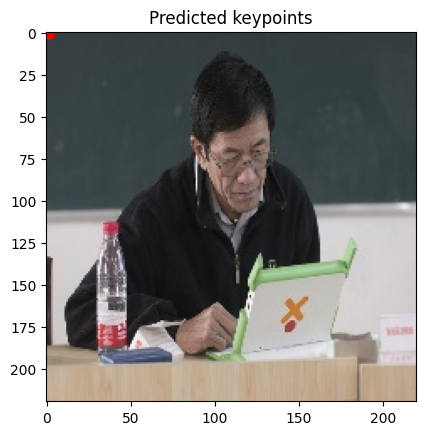

In [ ]:
#print a sample annotaion from the trained model
model.eval()
image, labels = next(iter(train_loader))
image, labels = image.to(device), labels.to(device)
outputs = model(image)
outputs = outputs.view(outputs.size(0), -1)
labels = labels.view(labels.size(0), -1)

#visualize the output
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_keypoints(image, keypoints, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # If keypoints is 2D with two columns, flatten it
    if keypoints.ndim == 2 and keypoints.shape[1] == 2:
        keypoints = keypoints.flatten()
    ax.imshow(image)
    for i in range(0, len(keypoints), 2):
        x, y = keypoints[i], keypoints[i + 1]
        ax.plot(x, y, 'ro')
    return ax

def plot_heatmaps(heatmaps, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(heatmaps[0, 0].cpu().detach().numpy())
    return ax

# Select a random image from the batch.
idx = random.randint(0, image.size(0) - 1)
img = image[idx].permute(1, 2, 0).cpu().detach().numpy()
label = labels[idx].cpu().detach().numpy()
output = outputs[idx].cpu().detach().numpy()
output = output.reshape(-1, 2)

print(output)
# Plot the image with the ground-truth keypoints.
fig, ax = plt.subplots()
label = label * 220
plot_keypoints(img, label, ax=ax)
plt.title('Ground-truth keypoints')
plt.show()

# Plot the image with the predicted keypoints.
fig, ax = plt.subplots()
plot_keypoints(img, output, ax=ax)
plt.title('Predicted keypoints')
plt.show()


